In [1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
#!pip3 install OSMPythonTools

In [3]:
!ls ../input/flight-delay-dataset-20182022/ | grep parquet

Combined_Flights_2018.parquet
Combined_Flights_2019.parquet
Combined_Flights_2020.parquet
Combined_Flights_2021.parquet
Combined_Flights_2022.parquet


In [4]:
columns_interested = ['Airline', 'Origin', 'Dest', 'Cancelled', 'Diverted', 'DepDelayMinutes',
       'ArrDelayMinutes','Distance', 'Year', 'Month', 'DayofMonth', 'DayOfWeek','Tail_Number']

In [5]:
years = [2018, 2019, 2020, 2021, 2022]
allFlights = []
for year in years:
    fileName = f"Combined_Flights_{year}"
    directoryName = "/kaggle/input/flight-delay-dataset-20182022/"+fileName+".parquet"
    allFlights.append(pd.read_parquet(directoryName,columns = columns_interested))
df = pd.concat(allFlights).reset_index(drop=True)
df = df.dropna()
del allFlights

In [6]:
df['Airline'] =  df['Airline'].astype(dtype='string')
df['Origin'] =  df['Origin'].astype(dtype='string')
df['Dest'] =  df['Dest'].astype(dtype='string')
df['Tail_Number'] =  df['Tail_Number'].astype(dtype='string')

In [7]:
df.dtypes

Airline             string
Origin              string
Dest                string
Cancelled             bool
Diverted              bool
DepDelayMinutes    float64
ArrDelayMinutes    float64
Distance           float64
Year                 int64
Month                int64
DayofMonth           int64
DayOfWeek            int64
Tail_Number         string
dtype: object

## Both arrival and departures delays have exponential distributions.

<AxesSubplot:title={'center':'Arrival Delays'}, ylabel='Frequency'>

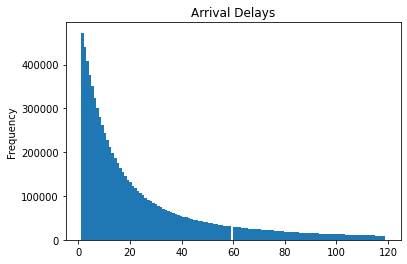

In [8]:
df.loc[(df['ArrDelayMinutes'] > 0.0) & (df['ArrDelayMinutes'] < 120.0)]['ArrDelayMinutes'].plot(kind='hist',bins=120, title="Arrival Delays")

<AxesSubplot:title={'center':'Departure Delays'}, ylabel='Frequency'>

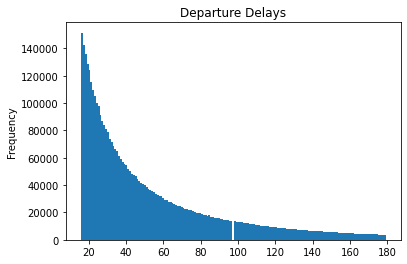

In [9]:
df.loc[(df['DepDelayMinutes'] > 15.0) & (df['DepDelayMinutes'] < 180.0)]['DepDelayMinutes'].plot(kind='hist',bins=165,title="Departure Delays")

According to FAA a flight is considered to be delayed when it is 15 minutes later than its scheduled time.

# Q: Which airports had the longest arrival and departure delays?

<AxesSubplot:title={'center':'Airports with most delays between 2018 and 2022'}, ylabel='Origin'>

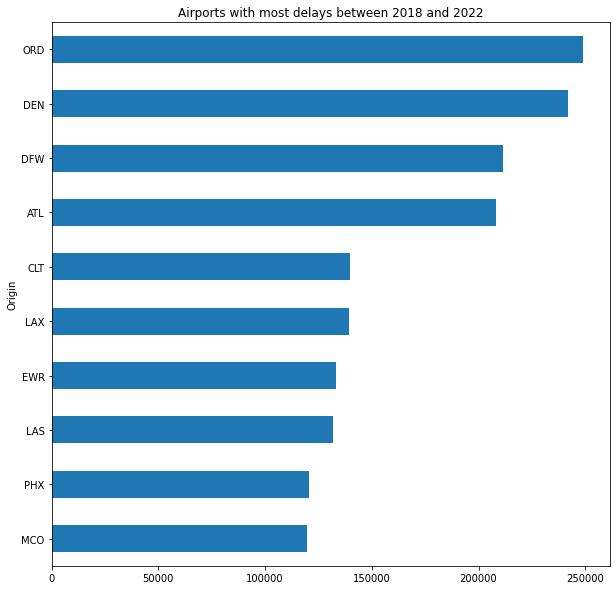

In [10]:
_df = df.loc[(df['DepDelayMinutes']>=15.0)].groupby('Origin').size().sort_values(ascending=True)
_df.tail(n=10).plot(kind = 'barh',figsize=(10,10), title="Airports with most delays between 2018 and 2022", ylabel="Sum of all delays in minutes")

<AxesSubplot:title={'center':'Most arrival delays per airport'}, ylabel='Dest'>

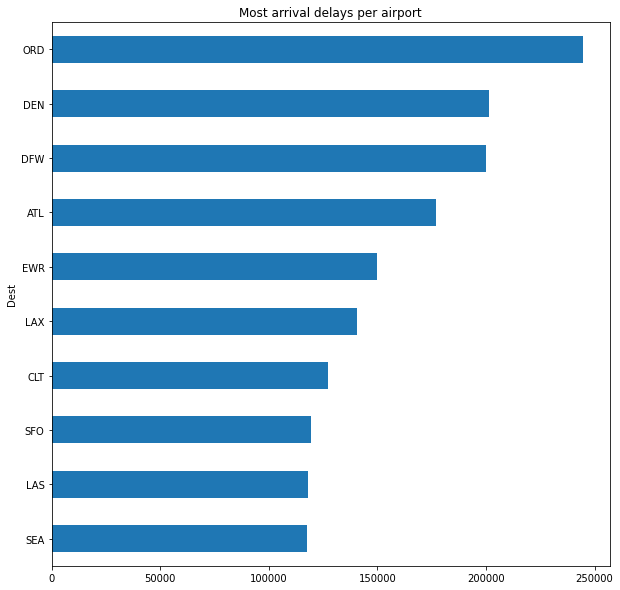

In [11]:
_df = df.loc[(df['ArrDelayMinutes']>=15.0)].groupby('Dest').size().sort_values(ascending=True)
_df.tail(n=10).plot(kind = 'barh',figsize=(10,10), title="Most arrival delays per airport")

**Chicago O'Hare, Denver, Dallas, Atlanta** airports had the highest cumulative delays both in arrival and departure.

# Q: Which airports had the highest percentage of delayed arrival and departure flights?

In [12]:
df['ArrDelay15Min'] = (df['ArrDelayMinutes']>=15.0)#.groupby('Dest').size().sort_values(ascending=True)
_df = df.groupby(['Dest','ArrDelay15Min']).size()
_df = _df.to_frame(name = 'size').reset_index()
_df['percentages'] = _df.groupby('Dest').apply(lambda x:100 * x / x.sum())['size']

<AxesSubplot:ylabel='Arrivals'>

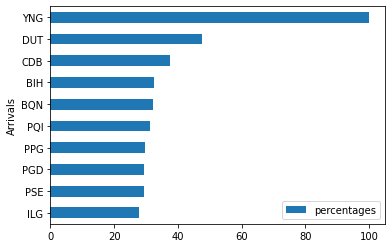

In [13]:
_df.loc[_df['ArrDelay15Min']==True].sort_values(by='percentages',ascending=True).tail(10).plot(kind='barh', x='Dest',y='percentages',ylabel="Percentage of arrivals delayed",xlabel="Arrivals")

In [14]:
df['DepDelay15Min'] = (df['DepDelayMinutes']>=15.0)
_df = df.groupby(['Origin','DepDelay15Min']).size()
_df = _df.to_frame(name = 'size').reset_index()
_df['percentages'] = _df.groupby('Origin').apply(lambda x:100 * x / x.sum())['size']

<AxesSubplot:ylabel='Origin'>

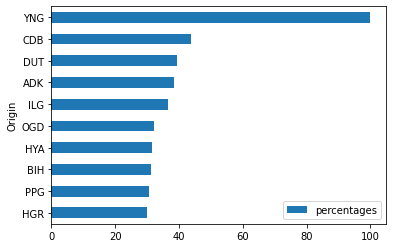

In [15]:
_df.loc[_df['DepDelay15Min']==True].sort_values(by='percentages',ascending=True).tail(10).plot(kind='barh', x='Origin',y='percentages',ylabel="Percentage of departures delayed",xlabel="Origin")

Most of these are small, regional airports.

# Q: Which airlines' flights were delayed for longest amount of time?

<AxesSubplot:title={'center':'Carriers with most delays between 2018 and 2022'}, ylabel='Airline'>

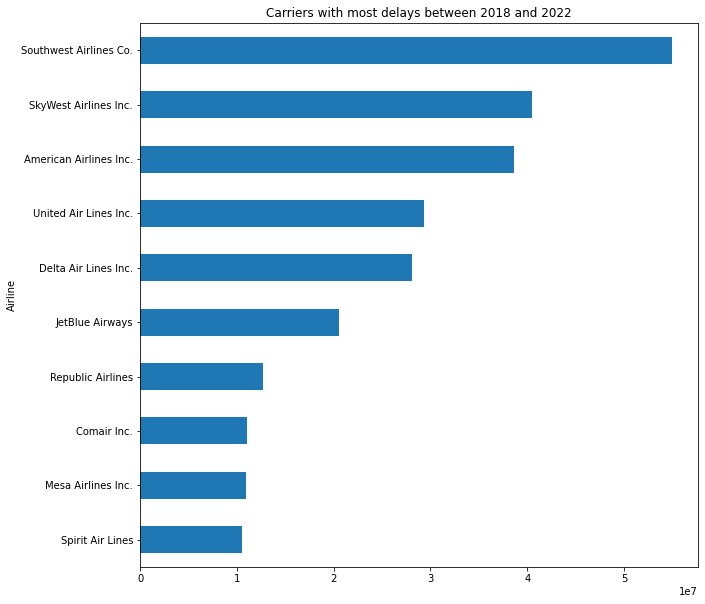

In [16]:
_df = df.loc[(df['DepDelayMinutes']>=15.0)].groupby('Airline')["DepDelayMinutes"].sum().sort_values(ascending=True)
_df.tail(n=10).plot(kind = 'barh',figsize=(10,10), title="Carriers with most delays between 2018 and 2022", ylabel="Sum of all delays in minutes")

# Q: Which airline was the most late?

<AxesSubplot:title={'center':'Carriers with most delays between 2018 and 2022'}, ylabel='Airline'>

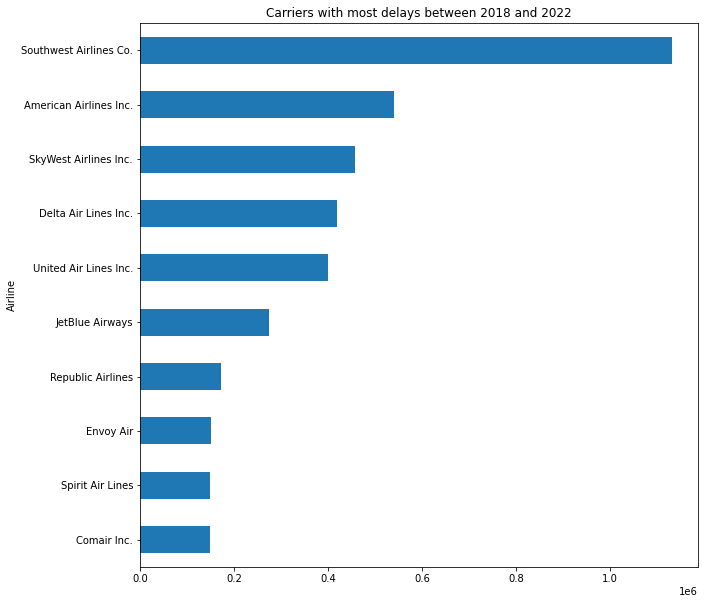

In [17]:
_df = df.loc[(df['DepDelayMinutes']>=15.0)].groupby('Airline')["DepDelayMinutes"].count().sort_values(ascending=True)
_df.tail(n=10).plot(kind = 'barh',figsize=(10,10), title="Carriers with most delays between 2018 and 2022", ylabel="Sum of all delays in minutes")

<AxesSubplot:ylabel='Airline'>

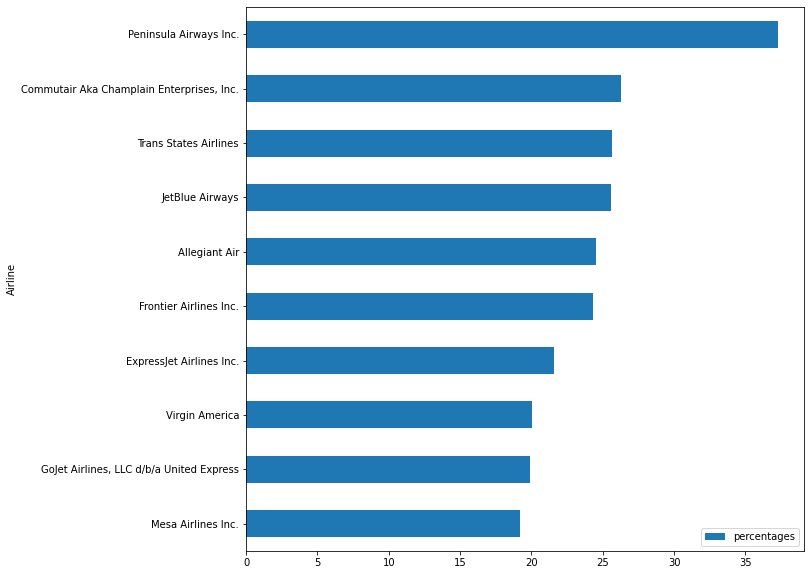

In [18]:
df['ArrDelay15Min'] = (df['ArrDelayMinutes']>=15.0)#.groupby('Dest').size().sort_values(ascending=True)
_df = df.groupby(['Airline','ArrDelay15Min']).size()
_df = _df.to_frame(name = 'size').reset_index()
_df['percentages'] = _df.groupby('Airline').apply(lambda x:100 * x / x.sum())['size']
_df.loc[_df['ArrDelay15Min']==True].sort_values(by='percentages',ascending=True).tail(10).plot(kind='barh', x='Airline',y='percentages',ylabel="Percentage of arrivals delayed",xlabel="Airline",figsize=(10,10))

<AxesSubplot:ylabel='Airline'>

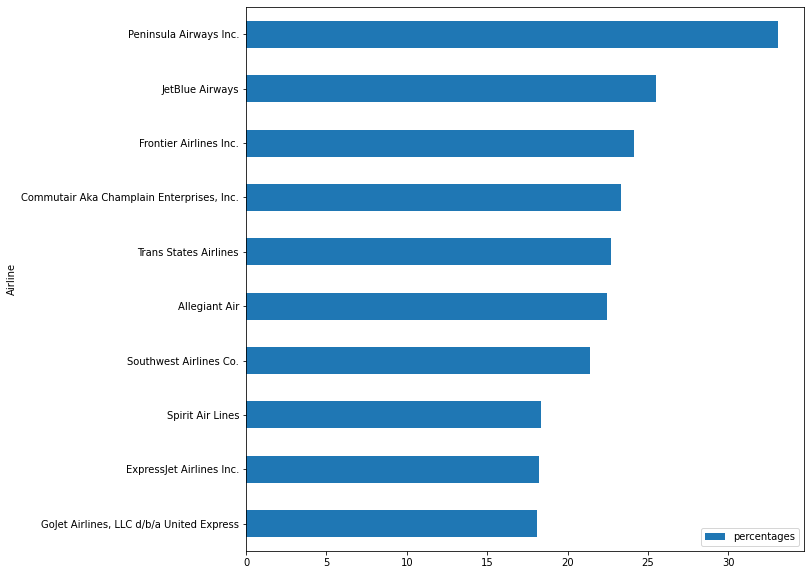

In [19]:
df['DeptDelay15Min'] = (df['DepDelayMinutes']>=15.0)#.groupby('Dest').size().sort_values(ascending=True)
_df = df.groupby(['Airline','DeptDelay15Min']).size()
_df = _df.to_frame(name = 'size').reset_index()
_df['percentages'] = _df.groupby('Airline').apply(lambda x:100 * x / x.sum())['size']
_df.loc[_df['DeptDelay15Min']==True].sort_values(by='percentages',ascending=True).tail(10).plot(kind='barh', x='Airline',y='percentages',ylabel="Percentage of departures delayed",xlabel="Airline",figsize=(10,10))

In [20]:
df.loc[(df['DepDelayMinutes']>=15.0)].groupby('Origin',as_index=False).sum()

,Origin,Cancelled,Diverted,DepDelayMinutes,ArrDelayMinutes,Distance,Year,Month,DayofMonth,DayOfWeek,ArrDelay15Min,DepDelay15Min,DeptDelay15Min
0,ABE,0,0,299116.0,281973.0,2036598.0,6574305,20836,51826,13239,2678,3255,3255
1,ABI,0,0,93032.0,91271.0,182144.0,2221910,7337,16839,4306,965,1100,1100
2,ABQ,0,0,976719.0,911132.0,9739540.0,29323486,95399,233833,58752,11613,14519,14519
3,ABR,0,0,46344.0,43606.0,93291.0,733275,2488,5560,1436,299,363,363
4,ABY,0,0,40204.0,39357.0,59450.0,828144,2552,6194,1564,360,410,410
...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,XWA,0,0,71080.0,68737.0,302656.0,1066917,3711,8181,2055,444,528,528
384,YAK,0,0,18338.0,19203.0,75009.0,733308,2378,5724,1509,337,363,363
385,YKM,0,0,28037.0,28038.0,55208.0,1082370,3318,8172,2074,486,536,536
386,YNG,0,0,126.0,150.0,1788.0,4036,2,5,5,1,2,2


In [21]:
df.loc[(df['DepDelayMinutes']>=15.0)].groupby('Origin',as_index=False).sum()

,Origin,Cancelled,Diverted,DepDelayMinutes,ArrDelayMinutes,Distance,Year,Month,DayofMonth,DayOfWeek,ArrDelay15Min,DepDelay15Min,DeptDelay15Min
0,ABE,0,0,299116.0,281973.0,2036598.0,6574305,20836,51826,13239,2678,3255,3255
1,ABI,0,0,93032.0,91271.0,182144.0,2221910,7337,16839,4306,965,1100,1100
2,ABQ,0,0,976719.0,911132.0,9739540.0,29323486,95399,233833,58752,11613,14519,14519
3,ABR,0,0,46344.0,43606.0,93291.0,733275,2488,5560,1436,299,363,363
4,ABY,0,0,40204.0,39357.0,59450.0,828144,2552,6194,1564,360,410,410
...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,XWA,0,0,71080.0,68737.0,302656.0,1066917,3711,8181,2055,444,528,528
384,YAK,0,0,18338.0,19203.0,75009.0,733308,2378,5724,1509,337,363,363
385,YKM,0,0,28037.0,28038.0,55208.0,1082370,3318,8172,2074,486,536,536
386,YNG,0,0,126.0,150.0,1788.0,4036,2,5,5,1,2,2


In [22]:
df['flight_per_day'] = df['Distance'].div(df['Year'])

In [23]:
df

,Airline,Origin,Dest,Cancelled,Diverted,DepDelayMinutes,ArrDelayMinutes,Distance,Year,Month,DayofMonth,DayOfWeek,Tail_Number,ArrDelay15Min,DepDelay15Min,DeptDelay15Min,flight_per_day
0,Endeavor Air Inc.,ABY,ATL,False,False,0.0,0.0,145.0,2018,1,23,2,N8928A,False,False,False,0.071853
1,Endeavor Air Inc.,ABY,ATL,False,False,0.0,0.0,145.0,2018,1,24,3,N800AY,False,False,False,0.071853
2,Endeavor Air Inc.,ABY,ATL,False,False,0.0,0.0,145.0,2018,1,25,4,N8836A,False,False,False,0.071853
3,Endeavor Air Inc.,ABY,ATL,False,False,0.0,0.0,145.0,2018,1,26,5,N800AY,False,False,False,0.071853
4,Endeavor Air Inc.,ABY,ATL,False,False,0.0,0.0,145.0,2018,1,27,6,N8839E,False,False,False,0.071853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29193772,Republic Airlines,EYW,EWR,False,False,216.0,207.0,1196.0,2022,3,31,4,N655RW,True,True,True,0.591494
29193773,Republic Airlines,CLE,EWR,False,False,223.0,201.0,404.0,2022,3,31,4,N656RW,True,True,True,0.199802
29193774,Republic Airlines,IAD,PIT,False,False,195.0,180.0,182.0,2022,3,31,4,N650RW,True,True,True,0.090010
29193776,Republic Airlines,EWR,MEM,False,False,154.0,135.0,946.0,2022,3,19,6,N728YX,True,True,True,0.467854
